In [ ]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms

# Init

In [ ]:
torch.manual_seed(43)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_ds, val_ds = random_split(dataset, [40000, 10000])
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

image_datasets = {'train': train_ds, 'val': val_ds, 'test': test_ds}

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# train_transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.RandomHorizontalFlip(p=.40),
#     transforms.RandomRotation(30),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# test_transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, accuracy_stats, loss_stats):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            loss_stats[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            accuracy_stats[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def evaluate(model, phase):
    model.eval()  

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    return epoch_loss, epoch_acc    

# Part 1

In [ ]:
model_rn = models.resnet18(pretrained=False)
num_ftrs = model_rn.fc.in_features
model_rn.fc = nn.Linear(num_ftrs, 10)

# model_ft.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 256), nn.ReLU(), nn.Dropout(0.4),
#     nn.Linear(256, 10), nn.LogSoftmax(dim=1))

model_rn = model_rn.to(device)


criterion = nn.CrossEntropyLoss()
optimizer_rn = optim.Adam(model_rn.parameters(), lr=0.01)
exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_rn, T_max=200)

In [ ]:
model_rn

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
accuracy_rn = {'train': [], 'val': []}
loss_rn = {'train': [], 'val': []}
num_epochs = 20
model_rn = train_model(model_rn, criterion, optimizer_rn, exp_lr_scheduler, num_epochs, accuracy_rn, loss_rn)

Epoch 0/19
----------
train Loss: 1.8218 Acc: 0.3584
val Loss: 1.4708 Acc: 0.4644

Epoch 1/19
----------
train Loss: 1.3544 Acc: 0.5164
val Loss: 1.4791 Acc: 0.5473

Epoch 2/19
----------
train Loss: 1.0879 Acc: 0.6133
val Loss: 1.1385 Acc: 0.5948

Epoch 3/19
----------
train Loss: 0.9052 Acc: 0.6790
val Loss: 0.9095 Acc: 0.6782

Epoch 4/19
----------
train Loss: 0.7669 Acc: 0.7315
val Loss: 0.9572 Acc: 0.6716

Epoch 5/19
----------
train Loss: 0.6642 Acc: 0.7682
val Loss: 0.9631 Acc: 0.6782

Epoch 6/19
----------
train Loss: 0.5600 Acc: 0.8036
val Loss: 0.8472 Acc: 0.7137

Epoch 7/19
----------
train Loss: 0.4677 Acc: 0.8377
val Loss: 0.8824 Acc: 0.7189

Epoch 8/19
----------
train Loss: 0.3920 Acc: 0.8653
val Loss: 0.9103 Acc: 0.7221

Epoch 9/19
----------
train Loss: 0.3180 Acc: 0.8904
val Loss: 0.9503 Acc: 0.7186

Epoch 10/19
----------
train Loss: 0.2549 Acc: 0.9112
val Loss: 1.0068 Acc: 0.7221

Epoch 11/19
----------
train Loss: 0.2084 Acc: 0.9278
val Loss: 1.0979 Acc: 0.7267

Ep

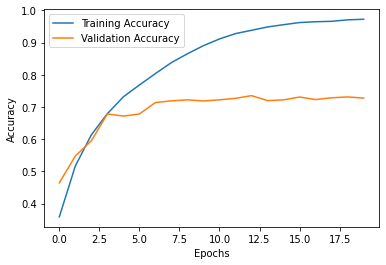

In [ ]:
plt.plot(accuracy_rn['train'], label='Training Accuracy')
plt.plot(accuracy_rn['val'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

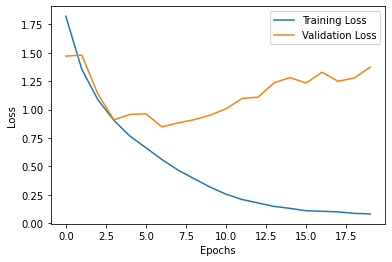

In [ ]:
plt.plot(loss_rn['train'], label='Training Loss')
plt.plot(loss_rn['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
_, train_acc_rn = evaluate(model_rn, 'train')
_, val_acc_rn = evaluate(model_rn, 'val')
_, test_acc_rn = evaluate(model_rn, 'test')

print('Training  Accuracy:   %.3f' % train_acc_rn)
print('Validation Accuracy:  %.3f' % val_acc_rn)
print('Testing Accuracy:     %.3f' % test_acc_rn)

Training  Accuracy:   0.970
Validation Accuracy:  0.735
Testing Accuracy:     0.734


# Part 2

Finetuning CONVNet

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

# model_ft.fc = nn.Sequential(
#     nn.Dropout(),
#     nn.Linear(num_ftrs, 10))

model_ft = model_ft.to(device)


criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=200)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
accuracy_ft = {'train': [], 'val': []}
loss_ft = {'train': [], 'val': []}
num_epochs = 20
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs, accuracy_ft, loss_ft)

Epoch 0/19
----------
train Loss: 0.9315 Acc: 0.6824
val Loss: 0.8008 Acc: 0.7244

Epoch 1/19
----------
train Loss: 0.5961 Acc: 0.7987
val Loss: 0.6530 Acc: 0.7817

Epoch 2/19
----------
train Loss: 0.4593 Acc: 0.8439
val Loss: 0.6430 Acc: 0.7847

Epoch 3/19
----------
train Loss: 0.3616 Acc: 0.8769
val Loss: 0.6548 Acc: 0.7891

Epoch 4/19
----------
train Loss: 0.2810 Acc: 0.9048
val Loss: 0.6415 Acc: 0.8060

Epoch 5/19
----------
train Loss: 0.2249 Acc: 0.9245
val Loss: 0.7213 Acc: 0.7888

Epoch 6/19
----------
train Loss: 0.1877 Acc: 0.9370
val Loss: 0.7289 Acc: 0.7975

Epoch 7/19
----------
train Loss: 0.1429 Acc: 0.9516
val Loss: 0.7597 Acc: 0.7961

Epoch 8/19
----------
train Loss: 0.1275 Acc: 0.9565
val Loss: 0.7981 Acc: 0.7969

Epoch 9/19
----------
train Loss: 0.1050 Acc: 0.9644
val Loss: 0.8372 Acc: 0.7969

Epoch 10/19
----------
train Loss: 0.1016 Acc: 0.9654
val Loss: 0.8712 Acc: 0.7949

Epoch 11/19
----------
train Loss: 0.0824 Acc: 0.9720
val Loss: 0.8381 Acc: 0.8043

Ep

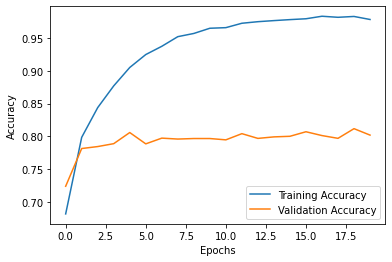

In [ ]:
plt.plot(accuracy_ft['train'], label='Training Accuracy')
plt.plot(accuracy_ft['val'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

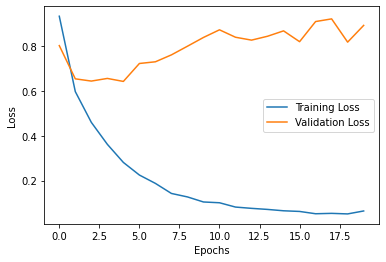

In [ ]:
plt.plot(loss_ft['train'], label='Training Loss')
plt.plot(loss_ft['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
_, train_acc_ft = evaluate(model_ft, 'train')
_, val_acc_ft = evaluate(model_ft, 'val')
_, test_acc_ft = evaluate(model_ft, 'test')

print('Training  Accuracy:   %.3f' % train_acc_ft)
print('Validation Accuracy:  %.3f' % val_acc_ft)
print('Testing Accuracy:     %.3f' % test_acc_ft)

Training  Accuracy:   0.992
Validation Accuracy:  0.812
Testing Accuracy:     0.803


ConvNet as fixed feature extractor (Model A)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)

count = 0
for name, child in model_conv.named_children():
    count += 1
    if count < 6:
        for name2, params in child.named_parameters():
            params.requires_grad = False


num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 10))

# model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)

exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_conv, T_max=200)

In [ ]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
accuracy_conv = {'train': [], 'val': []}
loss_conv = {'train': [], 'val': []}
num_epochs = 20
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs, accuracy_conv, loss_conv)

Epoch 0/19
----------
train Loss: 0.9048 Acc: 0.6956
val Loss: 0.7281 Acc: 0.7568

Epoch 1/19
----------
train Loss: 0.5763 Acc: 0.8108
val Loss: 0.6638 Acc: 0.7833

Epoch 2/19
----------
train Loss: 0.4396 Acc: 0.8582
val Loss: 0.6056 Acc: 0.8044

Epoch 3/19
----------
train Loss: 0.3410 Acc: 0.8901
val Loss: 0.6584 Acc: 0.7987

Epoch 4/19
----------
train Loss: 0.2579 Acc: 0.9160
val Loss: 0.6215 Acc: 0.8162

Epoch 5/19
----------
train Loss: 0.1955 Acc: 0.9362
val Loss: 0.7562 Acc: 0.7927

Epoch 6/19
----------
train Loss: 0.1543 Acc: 0.9506
val Loss: 0.7628 Acc: 0.8054

Epoch 7/19
----------
train Loss: 0.1296 Acc: 0.9582
val Loss: 0.8068 Acc: 0.8017

Epoch 8/19
----------
train Loss: 0.1083 Acc: 0.9639
val Loss: 0.8313 Acc: 0.7984

Epoch 9/19
----------
train Loss: 0.0929 Acc: 0.9698
val Loss: 0.8137 Acc: 0.8099

Epoch 10/19
----------
train Loss: 0.0814 Acc: 0.9744
val Loss: 0.8583 Acc: 0.8041

Epoch 11/19
----------
train Loss: 0.0721 Acc: 0.9771
val Loss: 0.8911 Acc: 0.8090

Ep

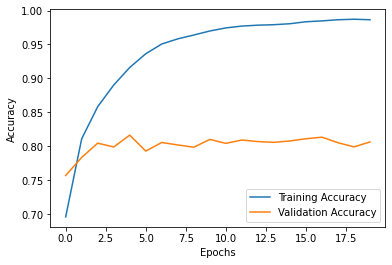

In [ ]:
plt.plot(accuracy_conv['train'], label='Training Accuracy')
plt.plot(accuracy_conv['val'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

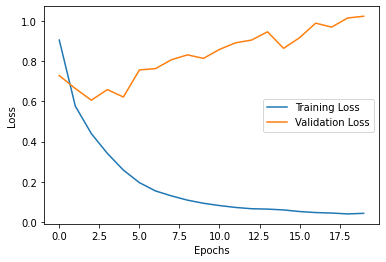

In [ ]:
plt.plot(loss_conv['train'], label='Training Loss')
plt.plot(loss_conv['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
_, train_acc_conv = evaluate(model_conv, 'train')
_, val_acc_conv = evaluate(model_conv, 'val')
_, test_acc_conv = evaluate(model_conv, 'test')

print('Training  Accuracy:   %.3f' % train_acc_conv)
print('Validation Accuracy:  %.3f' % val_acc_conv)
print('Testing Accuracy:     %.3f' % test_acc_conv)

Training  Accuracy:   0.964
Validation Accuracy:  0.816
Testing Accuracy:     0.815


CONVNET as fixed feature extractor(2)

In [ ]:
model_conv2 = torchvision.models.resnet18(pretrained=True)

count = 0
for name, child in model_conv.named_children():
    count += 1
    if count < 10:
        for name2, params in child.named_parameters():
            params.requires_grad = False

num_ftrs = model_conv2.fc.in_features

model_conv2.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 10))

# model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv2 = model_conv2.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv2 = optim.Adam(model_conv2.parameters(), lr=0.001)

exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_conv2, T_max=200)

In [ ]:
model_conv2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
accuracy_conv2 = {'train': [], 'val': []}
loss_conv2 = {'train': [], 'val': []}
num_epochs = 20
model_conv2 = train_model(model_conv2, criterion, optimizer_conv2, exp_lr_scheduler, num_epochs, accuracy_conv2, loss_conv2)

Epoch 0/19
----------
train Loss: 0.9605 Acc: 0.6800
val Loss: 0.8378 Acc: 0.7196

Epoch 1/19
----------
train Loss: 0.6389 Acc: 0.7899
val Loss: 0.7524 Acc: 0.7481

Epoch 2/19
----------
train Loss: 0.4930 Acc: 0.8365
val Loss: 0.6369 Acc: 0.7932

Epoch 3/19
----------
train Loss: 0.3943 Acc: 0.8695
val Loss: 0.6729 Acc: 0.7916

Epoch 4/19
----------
train Loss: 0.3152 Acc: 0.8997
val Loss: 0.6898 Acc: 0.7923

Epoch 5/19
----------
train Loss: 0.2498 Acc: 0.9193
val Loss: 0.6682 Acc: 0.8008

Epoch 6/19
----------
train Loss: 0.2150 Acc: 0.9297
val Loss: 0.7107 Acc: 0.7972

Epoch 7/19
----------
train Loss: 0.1642 Acc: 0.9470
val Loss: 0.7426 Acc: 0.7957

Epoch 8/19
----------
train Loss: 0.1399 Acc: 0.9548
val Loss: 0.7873 Acc: 0.7920

Epoch 9/19
----------
train Loss: 0.1275 Acc: 0.9588
val Loss: 0.7861 Acc: 0.7973

Epoch 10/19
----------
train Loss: 0.1089 Acc: 0.9650
val Loss: 0.8387 Acc: 0.8013

Epoch 11/19
----------
val Loss: 0.9368 Acc: 0.8002

Epoch 12/19
----------
train Loss

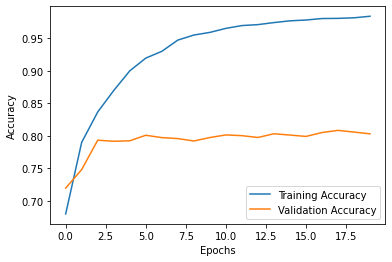

In [ ]:
plt.plot(accuracy_conv2['train'], label='Training Accuracy')
plt.plot(accuracy_conv2['val'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

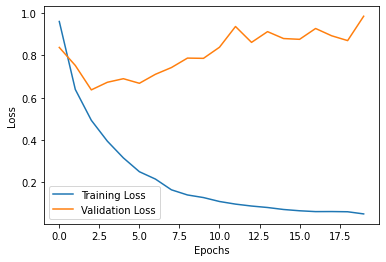

In [ ]:
plt.plot(loss_conv2['train'], label='Training Loss')
plt.plot(loss_conv2['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
_, train_acc_2 = evaluate(model_conv2, 'train')
_, val_acc_2 = evaluate(model_conv2, 'val')
_, test_acc_2 = evaluate(model_conv2, 'test')

print('Training  Accuracy:   %.3f' % train_acc_2)
print('Validation Accuracy:  %.3f' % val_acc_2)
print('Testing Accuracy:     %.3f' % test_acc_2)

Training  Accuracy:   0.990
Validation Accuracy:  0.808
Testing Accuracy:     0.805


Comparing above results

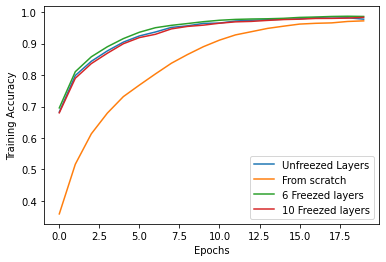

In [ ]:
plt.plot(accuracy_ft['train'], label='Unfreezed Layers')
plt.plot(accuracy_rn['train'], label='From scratch')
plt.plot(accuracy_conv['train'], label='6 Freezed layers')
plt.plot(accuracy_conv2['train'], label='10 Freezed layers')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()

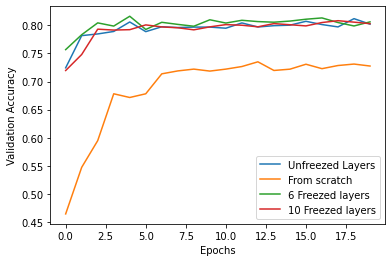

In [ ]:
plt.plot(accuracy_ft['val'], label='Unfreezed Layers')
plt.plot(accuracy_rn['val'], label='From scratch')
plt.plot(accuracy_conv['val'], label='6 Freezed layers')
plt.plot(accuracy_conv2['val'], label='10 Freezed layers')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

# Part 3

Mini CIFAR-10 with Data Augmentation

In [ ]:
torch.manual_seed(43)

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_ds, val_ds = random_split(dataset, [5000, 45000])
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

image_datasets = {'train': train_ds, 'val': test_ds, 'test': test_ds}

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


Varying Droprates

In [ ]:
droprates = [0.1, 0.2, 0.3, 0.4]
train_acc = []
test_acc = []

In [ ]:
for droprate in droprates:
    model_ft = models.resnet18(pretrained=False)
    num_ftrs = model_ft.fc.in_features

    model_ft.fc = nn.Sequential(
        nn.Dropout(droprate),
        nn.Linear(num_ftrs, 10))

    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
    exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=200)

    accuracy_ft = {'train': [], 'val': []}
    loss_ft = {'train': [], 'val': []}
    num_epochs = 10
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs, accuracy_ft, loss_ft)

    _, train_acc_ft = evaluate(model_ft, 'train')
    # _, val_acc_ft = evaluate(model_ft, 'val')
    _, test_acc_ft = evaluate(model_ft, 'test')

    print('Training  Accuracy:   %.3f' % train_acc_ft)
    # print('Validation Accuracy:  %.3f' % val_acc_ft)
    print('Testing Accuracy:     %.3f' % test_acc_ft)
    train_acc.append(train_acc_ft)
    test_acc.append(test_acc_ft)

Epoch 0/9
----------
train Loss: 2.0250 Acc: 0.2556
val Loss: 1.9848 Acc: 0.2891

Epoch 1/9
----------
train Loss: 1.7941 Acc: 0.3228
val Loss: 1.7955 Acc: 0.3424

Epoch 2/9
----------
train Loss: 1.6489 Acc: 0.4042
val Loss: 1.8763 Acc: 0.3162

Epoch 3/9
----------
train Loss: 1.5805 Acc: 0.4256
val Loss: 1.5551 Acc: 0.4232

Epoch 4/9
----------
train Loss: 1.4838 Acc: 0.4472
val Loss: 1.8402 Acc: 0.3970

Epoch 5/9
----------
train Loss: 1.4555 Acc: 0.4620
val Loss: 1.5305 Acc: 0.4237

Epoch 6/9
----------
train Loss: 1.3921 Acc: 0.4882
val Loss: 1.5987 Acc: 0.4242

Epoch 7/9
----------
train Loss: 1.3583 Acc: 0.4984
val Loss: 1.3439 Acc: 0.5098

Epoch 8/9
----------
train Loss: 1.3322 Acc: 0.5160
val Loss: 1.3896 Acc: 0.4986

Epoch 9/9
----------
train Loss: 1.2530 Acc: 0.5402
val Loss: 1.5263 Acc: 0.4708

Training complete in 6m 3s
Best val Acc: 0.509800
Training  Accuracy:   0.525
Testing Accuracy:     0.510
Epoch 0/9
----------
train Loss: 1.9890 Acc: 0.2734
val Loss: 2.0590 Acc: 

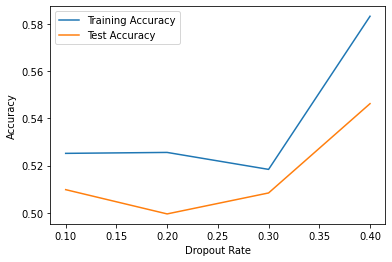

In [ ]:
plt.plot(droprates, train_acc, label='Training Accuracy')
plt.plot(droprates, test_acc, label='Test Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')
plt.legend()

# Final Model

In [ ]:
model_ft = models.resnet18(pretrained=False)
droprate = 0.3
num_ftrs = model_ft.fc.in_features

# model_rn.fc = nn.Linear(num_ftrs, 10)

model_ft.fc = nn.Sequential(
    nn.Dropout(droprate),
    nn.Linear(num_ftrs, 10))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=200)

In [ ]:
accuracy_ft = {'train': [], 'val': []}
loss_ft = {'train': [], 'val': []}
num_epochs = 50
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs, accuracy_ft, loss_ft)

Epoch 0/49
----------
train Loss: 1.4827 Acc: 0.4682
val Loss: 1.4013 Acc: 0.5152

Epoch 1/49
----------
train Loss: 1.0693 Acc: 0.6244
val Loss: 1.0688 Acc: 0.6193

Epoch 2/49
----------
train Loss: 0.8749 Acc: 0.6943
val Loss: 1.0452 Acc: 0.6346

Epoch 3/49
----------
train Loss: 0.7538 Acc: 0.7379
val Loss: 0.8420 Acc: 0.7062

Epoch 4/49
----------
train Loss: 0.6288 Acc: 0.7818
val Loss: 0.9187 Acc: 0.6937

Epoch 5/49
----------
train Loss: 0.5363 Acc: 0.8133
val Loss: 0.8307 Acc: 0.7288

Epoch 6/49
----------
train Loss: 0.4387 Acc: 0.8491
val Loss: 0.8511 Acc: 0.7271

Epoch 7/49
----------
train Loss: 0.3655 Acc: 0.8728
val Loss: 0.9374 Acc: 0.7189

Epoch 8/49
----------
train Loss: 0.3045 Acc: 0.8944
val Loss: 0.9322 Acc: 0.7250

Epoch 9/49
----------
train Loss: 0.2464 Acc: 0.9124
val Loss: 0.9721 Acc: 0.7290

Epoch 10/49
----------
train Loss: 0.1976 Acc: 0.9337
val Loss: 1.0187 Acc: 0.7210

Epoch 11/49
----------
train Loss: 0.1740 Acc: 0.9393
val Loss: 1.1337 Acc: 0.7145

Ep

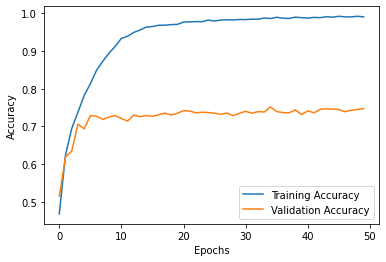

In [ ]:
plt.plot(accuracy_ft['train'], label='Training Accuracy')
plt.plot(accuracy_ft['val'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

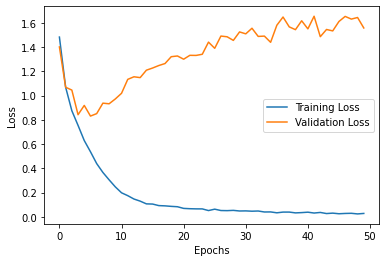

In [ ]:
plt.plot(loss_ft['train'], label='Training Loss')
plt.plot(loss_ft['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
_, train_acc_ft = evaluate(model_ft, 'train')
_, val_acc_ft = evaluate(model_ft, 'val')
_, test_acc_ft = evaluate(model_ft, 'test')

print('Training  Accuracy:   %.3f' % train_acc_ft)
print('Validation Accuracy:  %.3f' % val_acc_ft)
print('Testing Accuracy:     %.3f' % test_acc_ft)

Training  Accuracy:   0.995
Validation Accuracy:  0.752
Testing Accuracy:     0.753


# Part 4


Visualizing Activations

In [ ]:
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.datasets import cifar10
from keras.utils import to_categorical
import keras
from keras import backend as K
import tensorflow as tf

In [ ]:
new_input = Input(shape=(32, 32, 3))

model_rn = tf.keras.applications.ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=new_input,
    input_shape=None,
    pooling=None,
    classes=1000,
)

model = Sequential()
model.add(model_rn)
model.add(Dense(10))

In [ ]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX1 = trainX.astype('float32')
testX1 = testX.astype('float32')

trainX1 = trainX1 / 255.0
testX1 = testX1 / 255.0
trainY1 = to_categorical(trainY)
testY1 = to_categorical(testY)

In [ ]:
model.summary()

In [ ]:
col_size = 8
row_size = 8
layer_num = 2

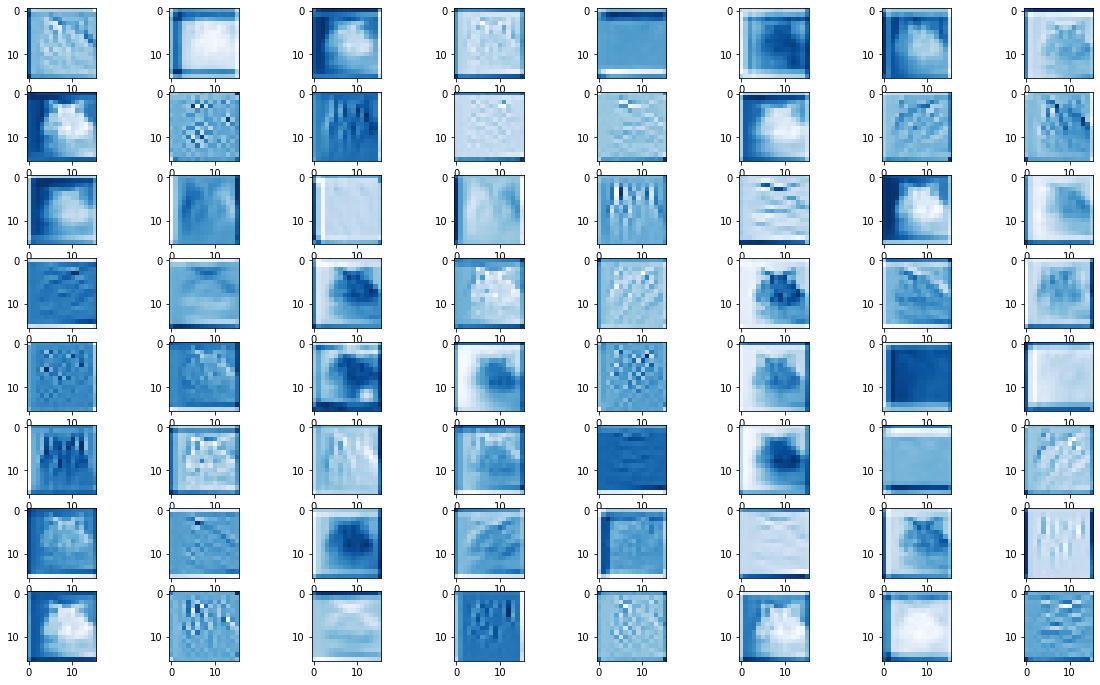

In [ ]:
from keras.models import Model
layer_outputs = []
for layer in model.layers:
    layer_outputs.append(layer.output)

visual_model = Model(inputs=model.input, outputs=layer_outputs)

activations = visual_model.predict(trainX1[1700].reshape(1,32,32,3))
 
activation = activations[layer_num]
channel_num = 0
fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))

for row in range(0,row_size):
    for col in range(0,col_size):
        ax[row][col].imshow(activation[0, :, :, channel_num], cmap='Blues')
        channel_num += 1

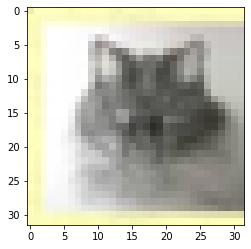

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(trainX1[1700][:,:,:]);

No. of filters- 64


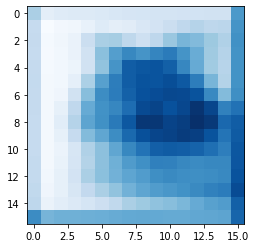

In [ ]:
layer_num = 2
channel_num = 45

activations = activation_model.predict(trainX1[1700].reshape(1,32,32,3))
activation = activations[layer_num]
print('No. of filters-', len(activation[0][0][0]))
plt.imshow(activation[0, :, :, channel_num], cmap='Blues')

NOTE - 

There are few parts of the assignment where we discussed some aspects with another group (Sarthak Garg, Varun Gupta and Gauri Gupta). This was on a collaborative level, such as sending some links to PyTorch tutorials and Transfer learning tutorials. In no way have copied, cheated or violated the code of conduct.
